In [51]:
import scipy
from matplotlib import pyplot as plt
from scipy.optimize import OptimizeResult

from core import approx
from core.gradient_descent import steepest_descent
from core.high_order_optimization import newton_optimize, LBFGSNewtonDirectionApproximator, gauss_newton, dogleg, \
    BFGSNewtonDirectionApproximator
from core.utils import mesuare_time, plot_approx
%load_ext autoreload
%autoreload 2

from core.optimizer_evaluator import *
from core.abstract_analzyer import *
import scipy
import torch.optim
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Сравнение `scipy.optimize.minimize` и `scipy.optimize.least_squares` с нашими методами

In [4]:
def loop(_):
    while True:
        pass
infinite = Algorithm("infinite", loop)
def err(_):
    raise Exception
error = Algorithm("error", err)
constantly = Algorithm("constantly", lambda _: "Hello")

compare_optimization_algorithms_in_table([infinite, error, constantly], [Problem("1", lambda x: x, [], lambda x: 1, None), Problem("2", lambda x: x, [], lambda x: 1, None)], 1)

=========== Testing infinite ===========
Got result TL at problem=1
Got result TL at problem=2
=========== Testing error ===========
Exception occurred: 
Got result × at problem=1
Exception occurred: 
Got result × at problem=2
=========== Testing constantly ===========
Got result Hello at problem=1
Got result Hello at problem=2
+-----------+------------+---------+--------------+
|   problem | infinite   | error   | constantly   |
+===========+============+=========+==============+
|         1 | TL         | ×       | Hello        |
+-----------+------------+---------+--------------+
|         2 | TL         | ×       | Hello        |
+-----------+------------+---------+--------------+


In [5]:
from scipy.optimize import HessianUpdateStrategy




In [65]:
def scipy_point_number_extractor(opt_res: OptimizeResult, elapsed: float):
    return opt_res.nit

def scipy_point_number_and_time_extractor(opt_res: OptimizeResult, elapsed: float):
    return f"{opt_res.nit}/{round(elapsed, 2)}"

In [66]:
def list_point_number_extractor(opt_res: list, elapsed: float):
    return len(opt_res)

def list_point_number_and_time_extractor(opt_res: list, elapsed: float):
    return f"{len(opt_res)}/{round(elapsed, 2)}"

In [8]:
def steps(iters):
    return lambda f, ps: len(ps) > iters

x = torch.linspace(-math.pi, math.pi, 200)
y = torch.sin(x)

nx = x.numpy()
ny = y.numpy()

handmade result = [ 7.99894401e-16  9.99430322e-01 -1.62996133e-15 -1.65816370e-01
  4.80721800e-16  7.99278115e-03 -3.12605868e-17 -1.47322333e-04], time = 0.21004748344421387s


[]

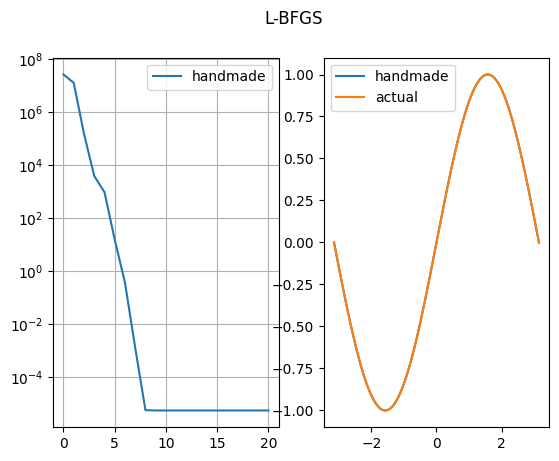

In [9]:
dump2, t = mesuare_time(lambda:
                        approx.polynom_approx(
                            nx, ny, 8,
                            lambda r, dr, f, df, x0: newton_optimize(f, df, LBFGSNewtonDirectionApproximator(10), x0, fibonacci_search(200), steps(20))
                        )
                        )
print(f"handmade result = {dump2.w}, time = {t}s")

plot_approx(nx, ny, [dump2]).suptitle('L-BFGS')
plt.plot()

handmade result = [-37.61486287 -20.79668622  -6.02349481  -1.68864636   1.26376234
   0.31749836], time = 0.057013511657714844s


[]

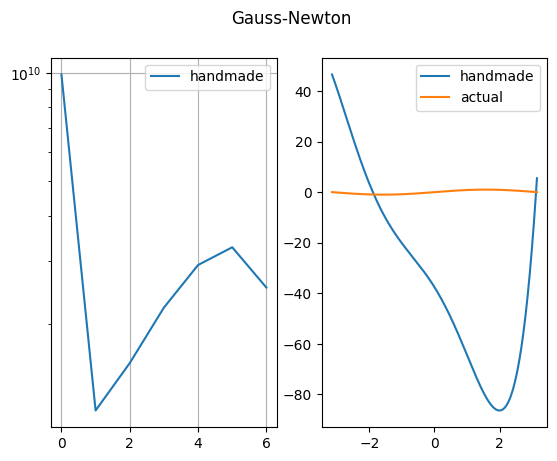

In [10]:
dump2, t = mesuare_time(lambda:
                        approx.polynom_approx_residuals(
                            nx, ny, 6,
                            lambda r, dr, f, df, x0: gauss_newton(r, dr, x0, steps(20))
                        )
                        )
print(f"handmade result = {dump2.w}, time = {t}s")

plot_approx(nx, ny, [dump2]).suptitle('Gauss-Newton')
plt.plot()

In [11]:
dump2, t = mesuare_time(lambda:
                        approx.polynom_approx_residuals(
                            nx, ny, 5,
                            lambda r, dr, f, df, x0: dogleg(r, dr, 1, fibonacci_search(50), x0, steps(100))
                        )
                        )
print(f"handmade result = {dump2.w}, time = {t}s")

plot_approx(nx, ny, [dump2]).suptitle('Dogleg')
plt.plot()

KeyboardInterrupt: 

# Таблица Сравнения


$${\displaystyle f({\boldsymbol {x}})=\sum _{i=1}^{n-1}\left[100\left(x_{i+1}-x_{i}^{2}\right)^{2}+\left(1-x_{i}\right)^{2}\right]}$$

$${\displaystyle q({\boldsymbol {x}})= x^T Q x$$



In [67]:
q_algorithms = [
    Algorithm.quasi_newton_optimize_with_strategy("L-BFGS[m=3]", lambda: LBFGSNewtonDirectionApproximator(5), list_point_number_and_time_extractor),
    Algorithm.quasi_newton_optimize_with_strategy("L-BFGS[m=10]", lambda: LBFGSNewtonDirectionApproximator(10), list_point_number_and_time_extractor),

    Algorithm.quasi_newton_optimize_with_strategy("BFGS", lambda: BFGSNewtonDirectionApproximator(), list_point_number_and_time_extractor),

    Algorithm.gradient_descent("Steepest", steepest_descent, list_point_number_and_time_extractor),

    Algorithm.scipy_optimize_with_solver("BFGS", scipy_point_number_and_time_extractor),
    Algorithm.scipy_optimize_with_solver("L-BFGS-B", scipy_point_number_and_time_extractor),
]

In [70]:
problems = [
    Problem.from_rosen(10),
    Problem.from_rosen(100),


    Problem.from_quadratic_form(generate_positive_definite_quadratic_form(50, 10)),
    Problem.from_quadratic_form(generate_positive_definite_quadratic_form(100, 10)),
    Problem.from_quadratic_form(generate_positive_definite_quadratic_form(100, 50)),
    Problem.from_quadratic_form(generate_positive_definite_quadratic_form(100, 500)),
    Problem.from_quadratic_form(generate_positive_definite_quadratic_form(300, 500)),
    # Problem.from_quadratic_form(generate_positive_definite_quadratic_form(1000, 500)),
]

In [71]:
compare_optimization_algorithms_in_table(q_algorithms, problems, 10)

=========== Testing hm.L-BFGS[m=3] ===========
Got result 85/0.04 at problem=Rosen[n=10]
Got result 583/0.37 at problem=Rosen[n=100]
Got result 41/0.01 at problem=Quadratic[n=50, k=10]
Got result 24/0.02 at problem=Quadratic[n=100, k=10]
Got result 39/0.04 at problem=Quadratic[n=100, k=50]
Got result 70/0.08 at problem=Quadratic[n=100, k=500]
Got result 86/0.16 at problem=Quadratic[n=300, k=500]
=========== Testing hm.L-BFGS[m=10] ===========
Got result 110/0.05 at problem=Rosen[n=10]
Got result 798/0.6 at problem=Rosen[n=100]
Got result 40/0.02 at problem=Quadratic[n=50, k=10]
Got result 66/0.11 at problem=Quadratic[n=100, k=10]
Got result 43/0.04 at problem=Quadratic[n=100, k=50]
Got result 86/0.11 at problem=Quadratic[n=100, k=500]
Got result 100/0.14 at problem=Quadratic[n=300, k=500]
=========== Testing hm.BFGS ===========
Got result 56/0.02 at problem=Rosen[n=10]
Exception occurred: 
Got result × at problem=Rosen[n=100]
Got result 60/0.02 at problem=Quadratic[n=50, k=10]
Got resu

# Выводы сравнения эффективности и производительности

- По количеству итераций — результаты сопоставимы,
- Однако затраченное время различается: алгоритмы на C/Fortran обычно работают быстрее.
    - Особенно разница заметна на L-BFGS: `0.16s` vs `0.02s` при ≈ одинаковом количестве итераций.
    - А вот для BFGS — разница на больщих размерностях небольшая, так как там более высокая часть времени занята именно работой с матрицами, которая производится на Fortran-е (на нём написан numpy).


# Сравнение scipy с ограничениями и без них